In [ ]:
## goal is to use data from a mental health survey to explore factors that may cause individuals to experience depression.

In [ ]:
!pip install squarify
!pip install category_encoders
!pip install catboost

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print("First 5 rows of our dataset:")
df_train.head()

First 5 rows of our dataset:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
print(f"There are {df_train.shape[1]} columns and {df_train.shape[0]} rows in the train dataset.")

There are 20 columns and 140700 rows in the train dataset.


In [ ]:
print("Column names and data type of each column:")
df_train.dtypes

Column names and data type of each column:


,0
id,int64
Name,object
Gender,object
Age,float64
City,object
Working Professional or Student,object
Profession,object
Academic Pressure,float64
Work Pressure,float64
CGPA,float64


In [ ]:
print("There are {} duplicates in the dataset.".format(df_train.duplicated().sum()))

There are 0 duplicates in the dataset.


In [ ]:
print("Checking for missing values in each column:")
print(df_train.isnull().sum())

Checking for missing values in each column:
id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                  

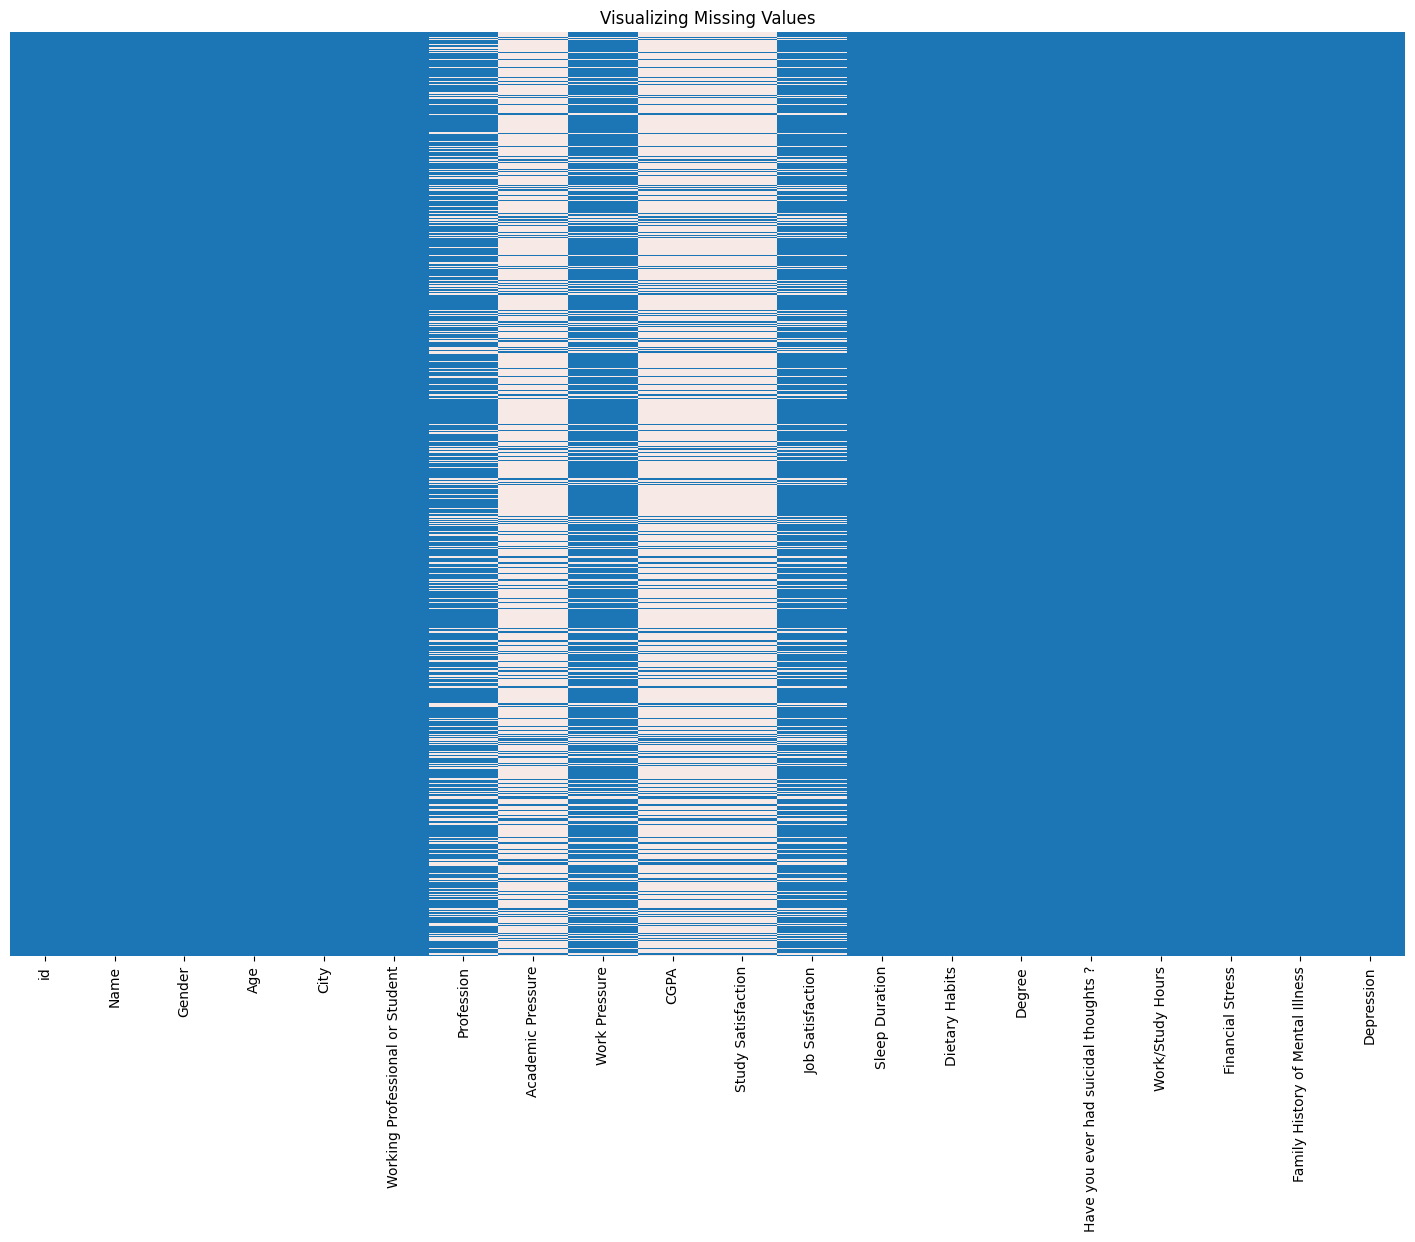

In [ ]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

In [ ]:
# Save 'id' column for submission
test_ids = df_test['id']

# Drop 'id' column in both datasets
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

# Define the target column
target_column = 'Depression'

# Select categorical and numerical columns (initial)
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Depression

Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


In [ ]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Name' has 422 unique categories.
'Gender' has 2 unique categories.
'City' has 98 unique categories.
'Working Professional or Student' has 2 unique categories.
'Profession' has 64 unique categories.
'Sleep Duration' has 36 unique categories.
'Dietary Habits' has 23 unique categories.
'Degree' has 115 unique categories.
'Have you ever had suicidal thoughts ?' has 2 unique categories.
'Family History of Mental Illness' has 2 unique categories.


In [ ]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df_train[column].value_counts().head(10)}")


Top value counts in 'Name':
Name
Rohan          3178
Aarav          2336
Rupak          2176
Aaradhya       2045
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1596
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

Top value counts in 'Gender':
Gender
Male      77464
Female    63236
Name: count, dtype: int64

Top value counts in 'City':
City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Name: count, dtype: int64

Top value counts in 'Working Professional or Student':
Working Professional or Student
Working Professional    112799
Student                  27901
Name: count, dtype: int64

Top value counts in 'Profession':
Profession
Teacher             24906
Content Writer       7814
Architect            4370
Consultant           4229
HR Manager           4022
Pharmacist  

In [ ]:
print("The skewness of columns:")
print(df_train[numerical_columns].skew())

The skewness of columns:
Age                  -0.217977
Academic Pressure    -0.133977
Work Pressure         0.018515
CGPA                 -0.073636
Study Satisfaction    0.011764
Job Satisfaction      0.054361
Work/Study Hours     -0.128169
Financial Stress      0.035603
dtype: float64


EDA

3.1. Distribution of Numerical Variables

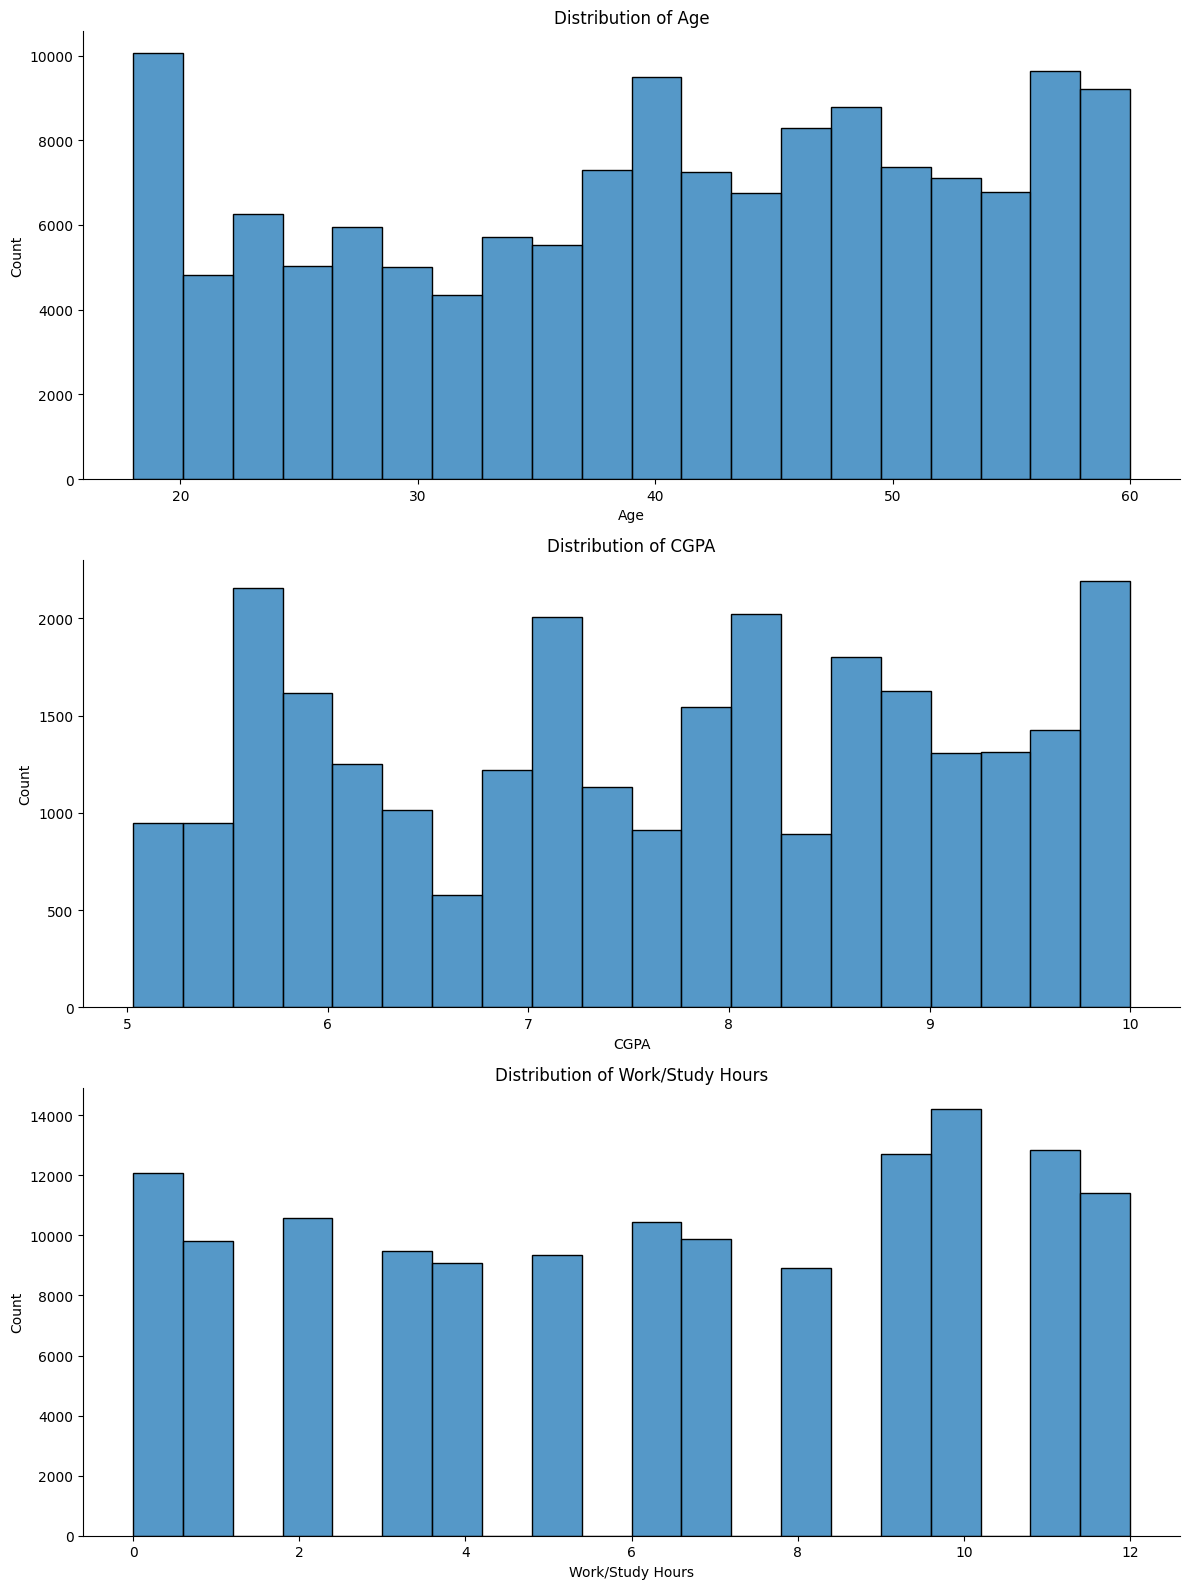

In [ ]:
numerical_columns_to_plot = ["Age", "CGPA", "Work/Study Hours"]

plt.figure(figsize=(12, 16))

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(3, 1, i+1)
    sns.histplot(data=df_train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

3.2. Distribution of Categorical Features

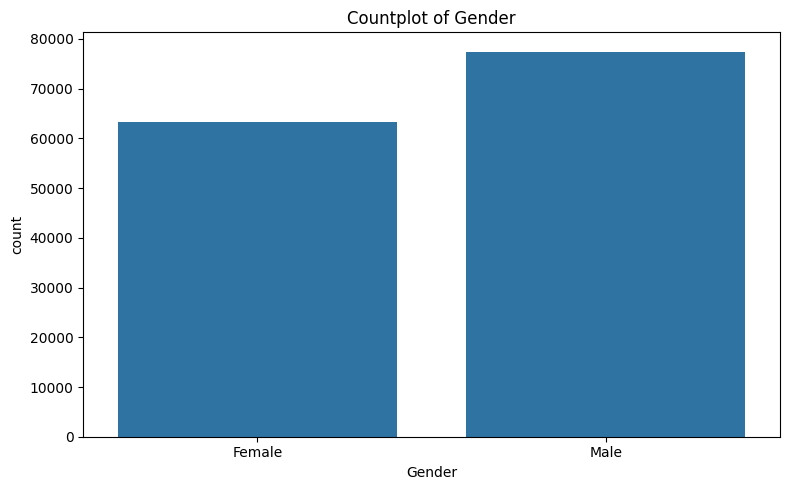

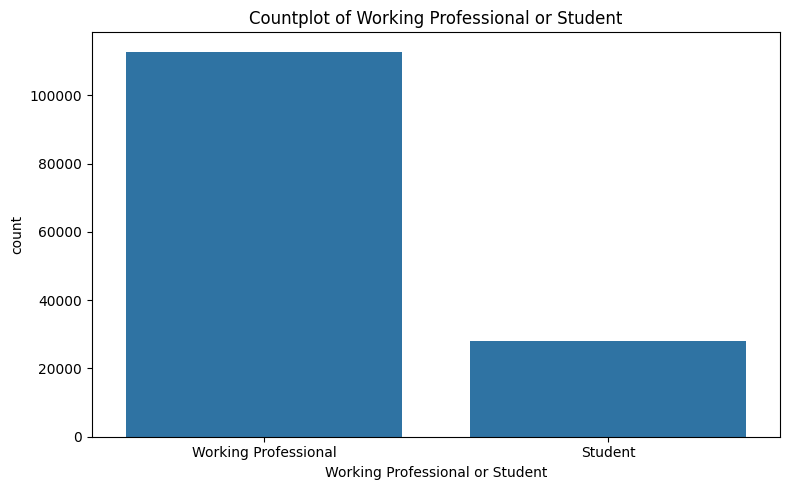

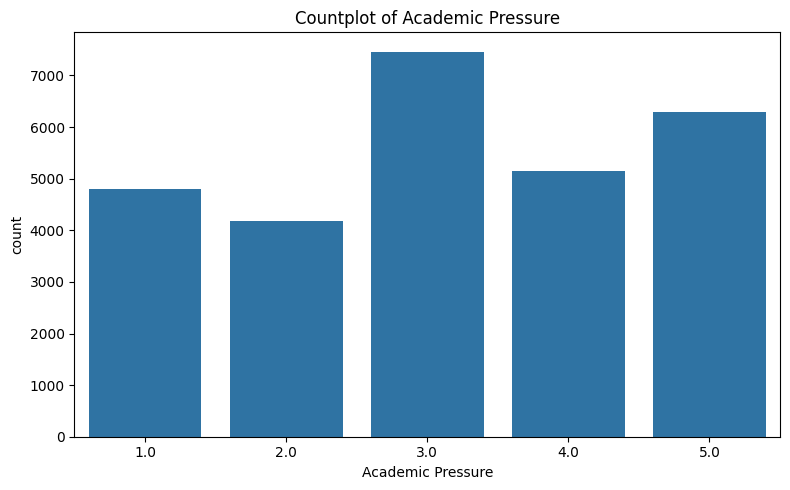

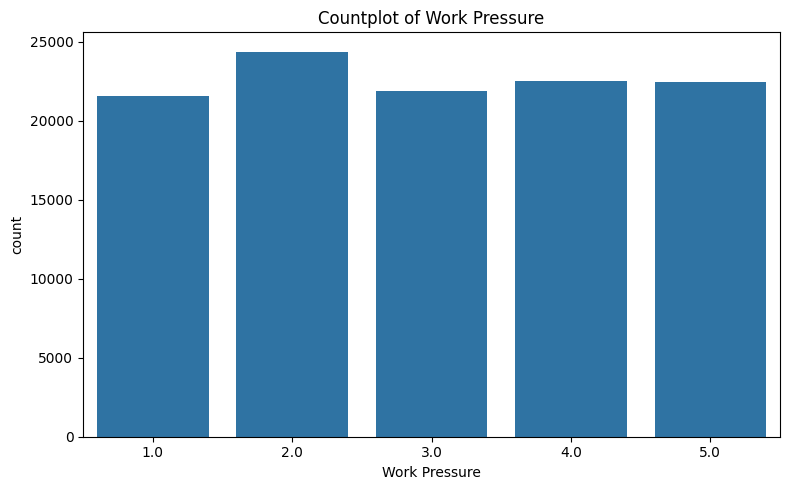

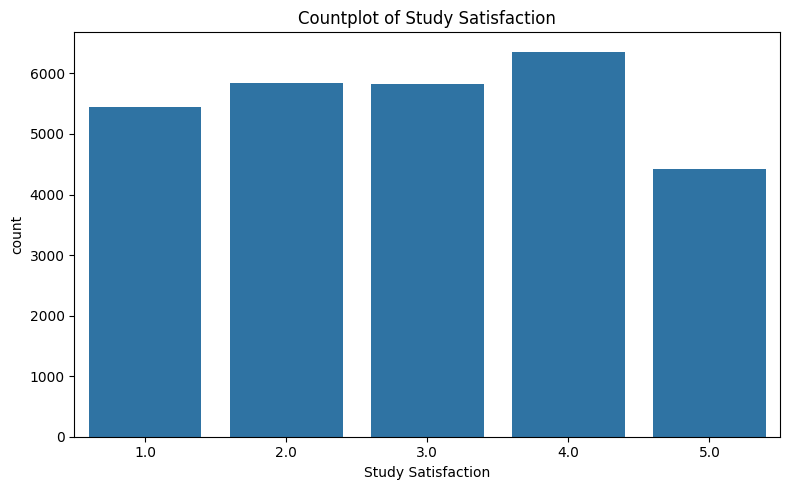

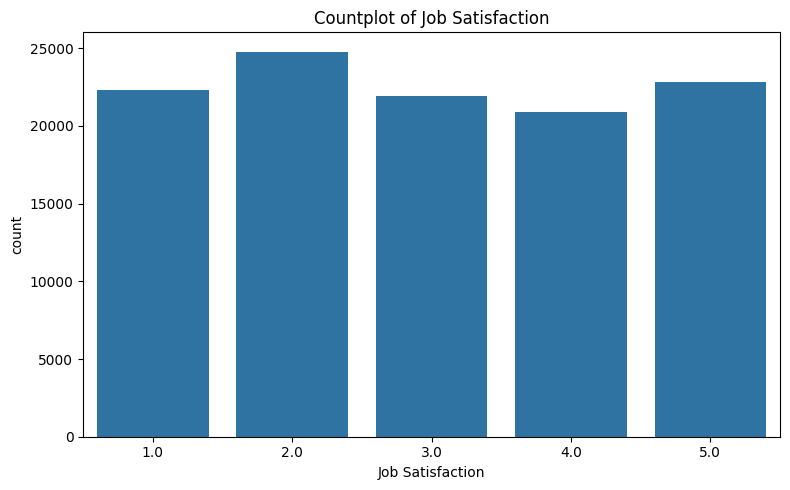

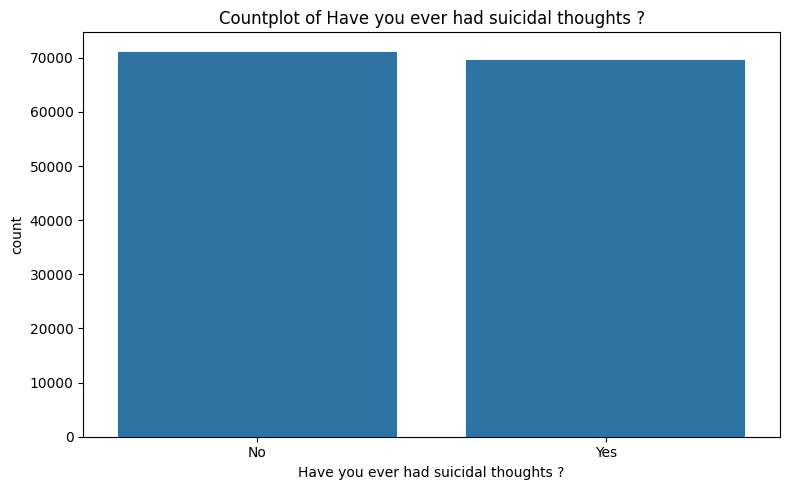

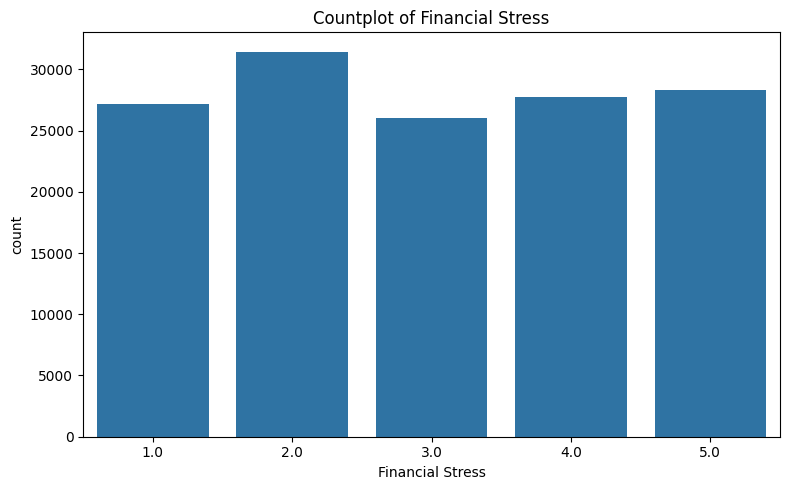

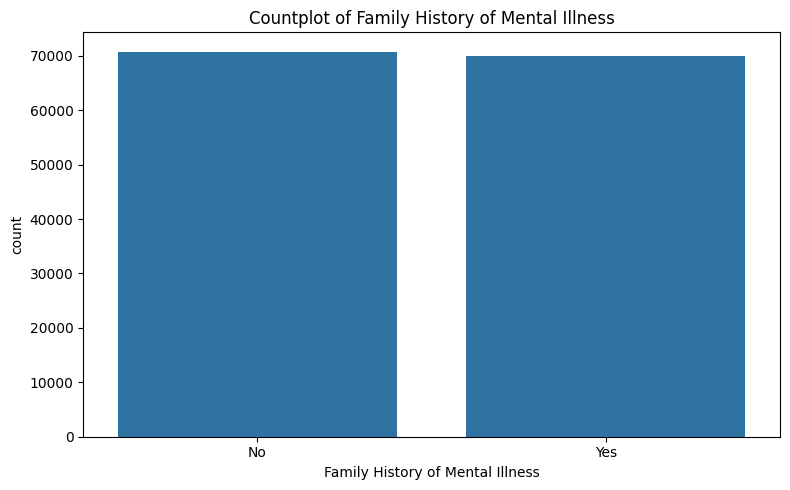

In [ ]:
categorical_columns_to_plot = ['Gender', 'Working Professional or Student', 'Academic Pressure',
                       'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                       'Have you ever had suicidal thoughts ?', 'Financial Stress',
                       'Family History of Mental Illness']

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Countplot of {column}')

    plt.tight_layout()
    plt.show()

3.3. Distribution of Numerical Features by Presence of Depression

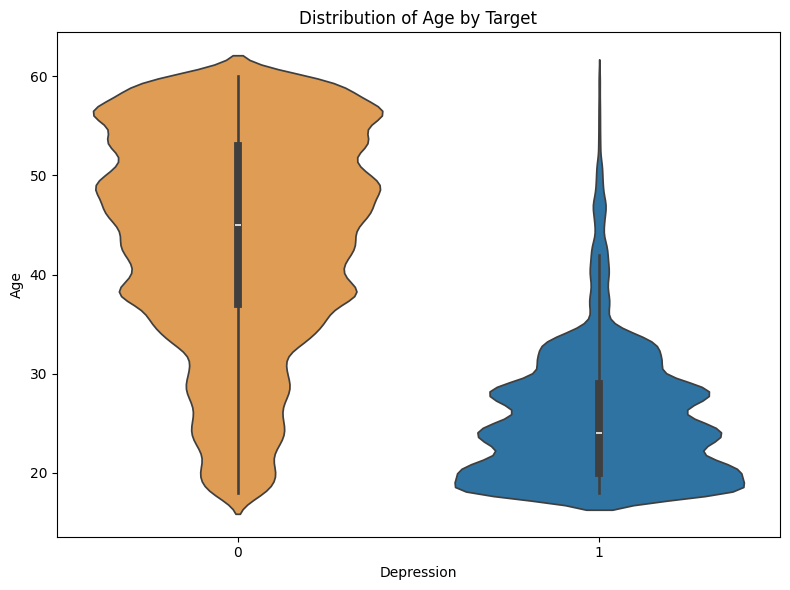

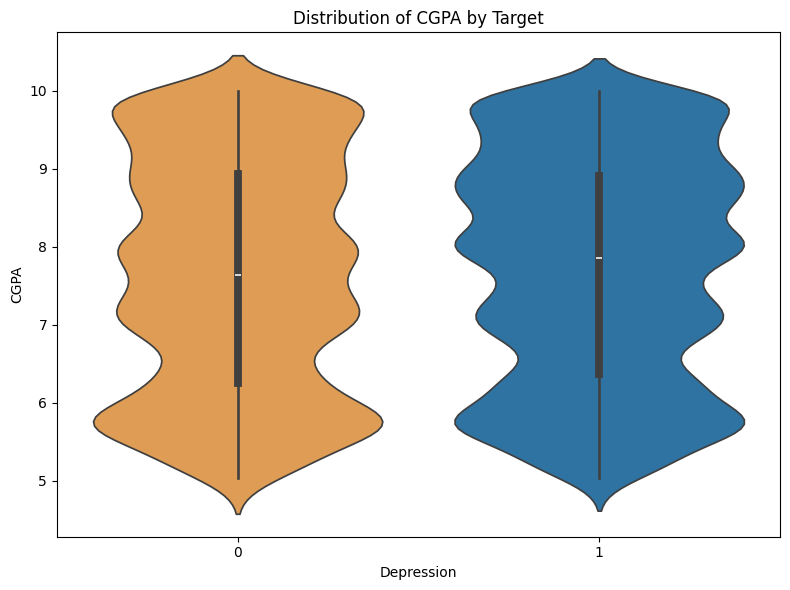

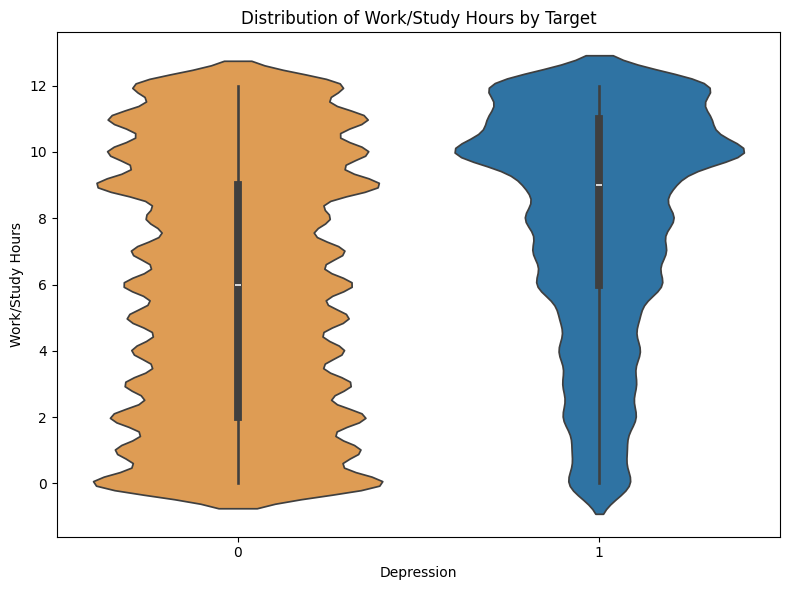

In [ ]:
bi_palette = [colors[3], colors[0]]

for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_train, x=target_column, y=column, palette=bi_palette)
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.show()

3.4. Relationship of Categorical Columns with a Target Variable

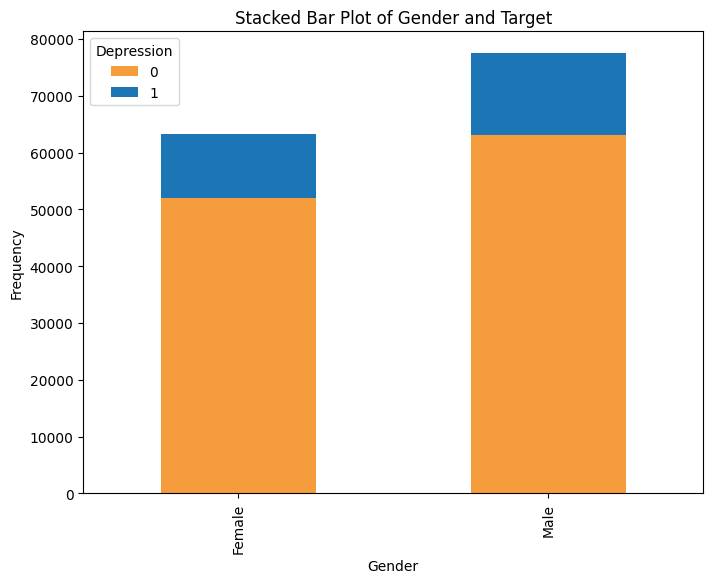

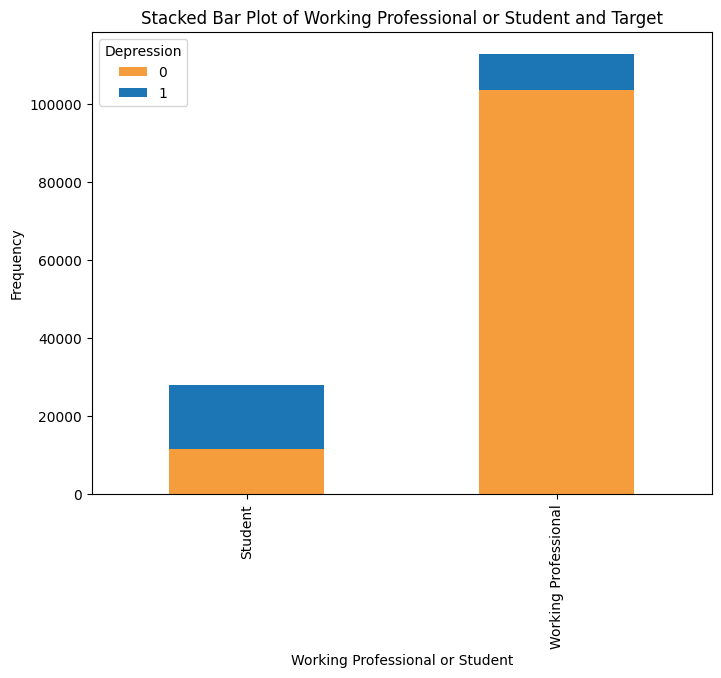

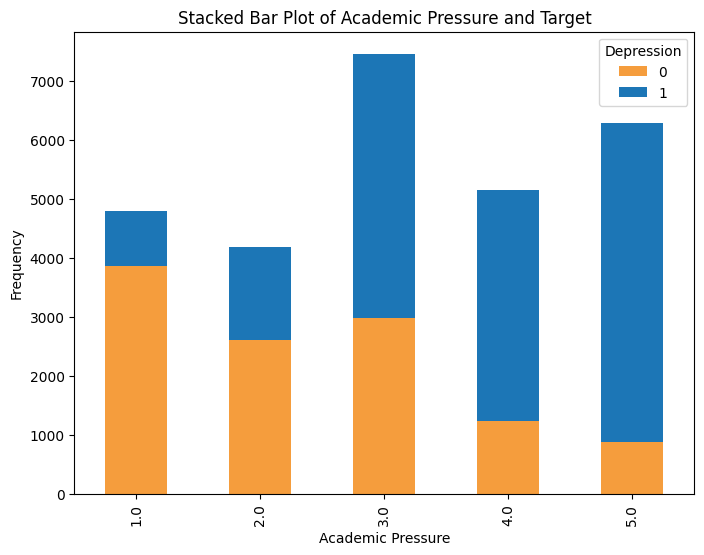

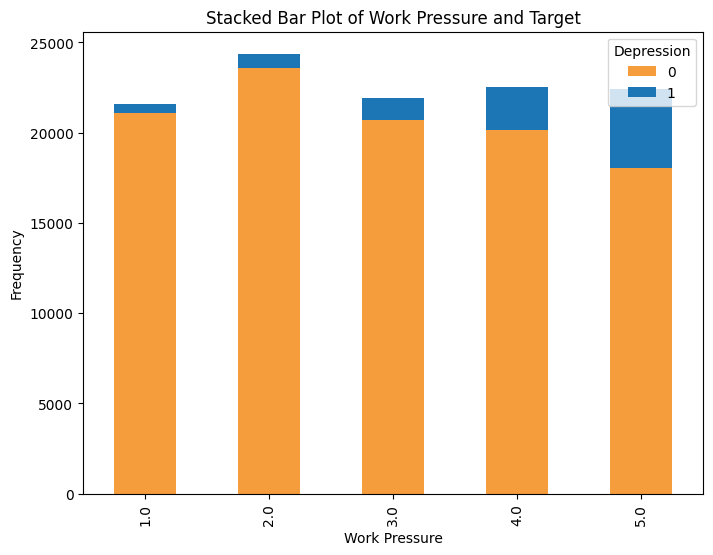

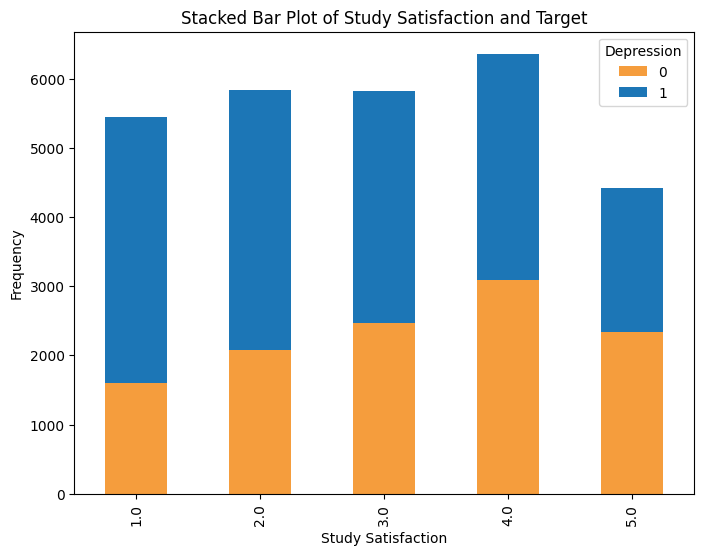

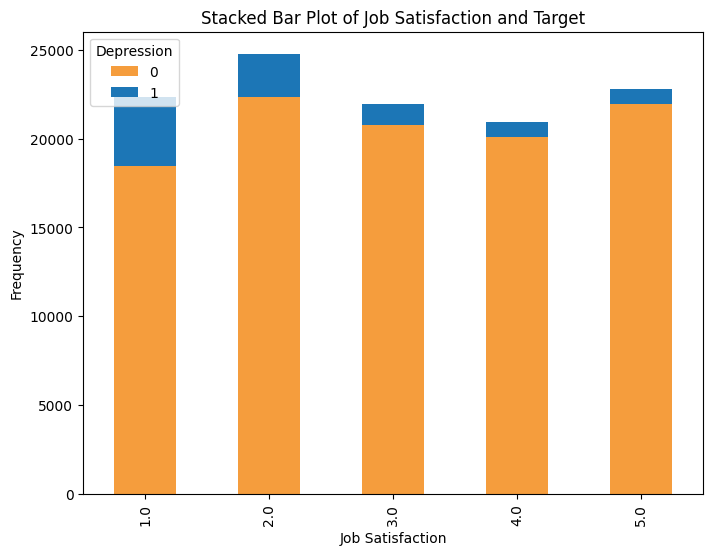

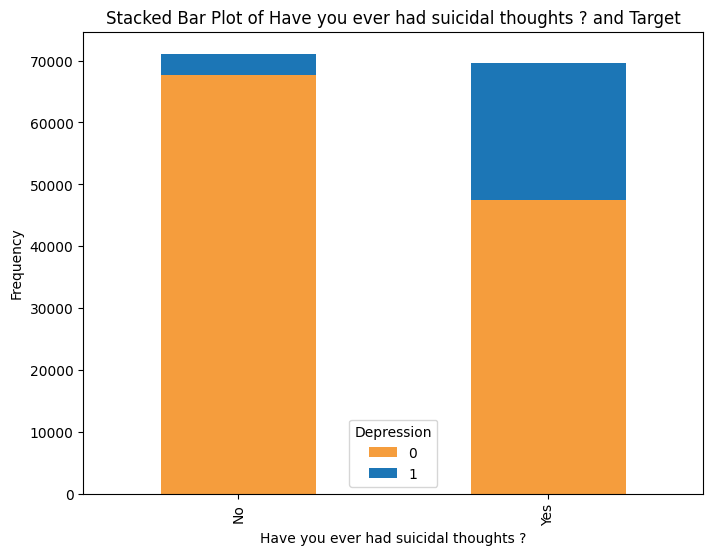

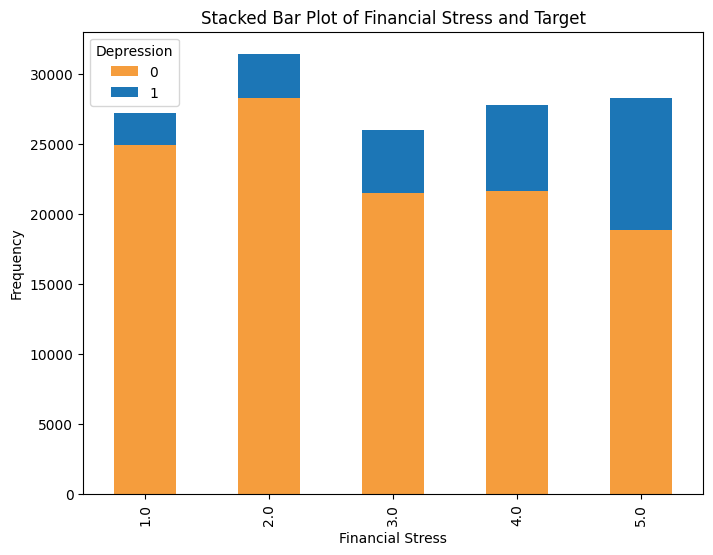

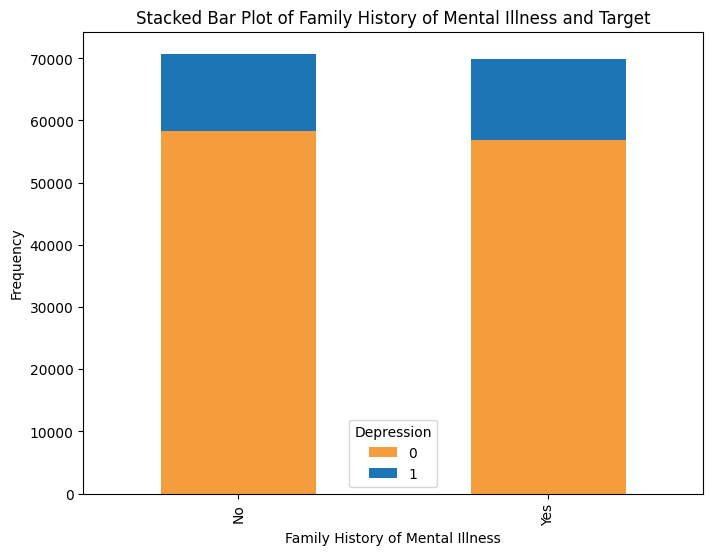

In [ ]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", bi_palette)

# Loop through each categorical column in your list
for column in categorical_columns_to_plot:
    # Stacked Bar Plot
    pd.crosstab(df_train[column], df_train[target_column]).plot(kind='bar', stacked=True, colormap=cmap, figsize=(8, 6))
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

3.5. Exploring Professions

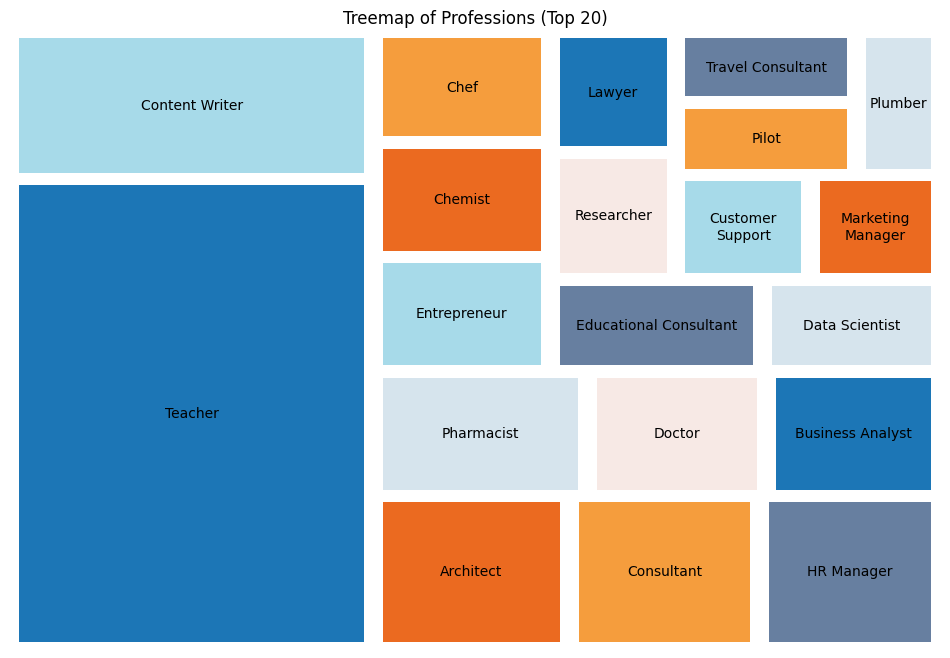

In [ ]:
# Calculate frequencies
value_counts = df_train['Profession'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

# Modify specific labels to show on two lines and limit to top 20 labels
labels = [
    "Customer\nSupport" if label == "Customer Support" else
    "Marketing\nManager" if label == "Marketing Manager" else
    label
    for label in value_counts.index[:20]
]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, pad=True)
plt.title(f"Treemap of Professions (Top 20)")
plt.axis("off")
plt.show()


In [ ]:
# Create a DataFrame for the top 20 professions and their relationship with depression
top_n_professions = 20
profession_counts = df_train['Profession'].value_counts().nlargest(top_n_professions)
filtered_data = df_train[df_train['Profession'].isin(profession_counts.index)]

# Create a summary DataFrame
sankey_data = filtered_data.groupby(['Profession', 'Depression']).size().reset_index(name='Count')

# Define the source and target for the Sankey chart
labels = list(sankey_data['Profession'].unique()) + ['No Depression', 'Depression']
source_indices = []
target_indices = []

for _, row in sankey_data.iterrows():
    profession_index = labels.index(row['Profession'])
    depression_index = labels.index('Depression' if row['Depression'] == 1 else 'No Depression')
    source_indices.append(profession_index)
    target_indices.append(depression_index)

# Create a Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source_indices,  # Indices correspond to labels, e.g., A=0, B=1, C=2...
        target=target_indices,
        value=sankey_data['Count']
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Profession and Depression",
    font_size=10,
    width=700,
    height=600)

fig.show()

3.6. Exploring Degrees

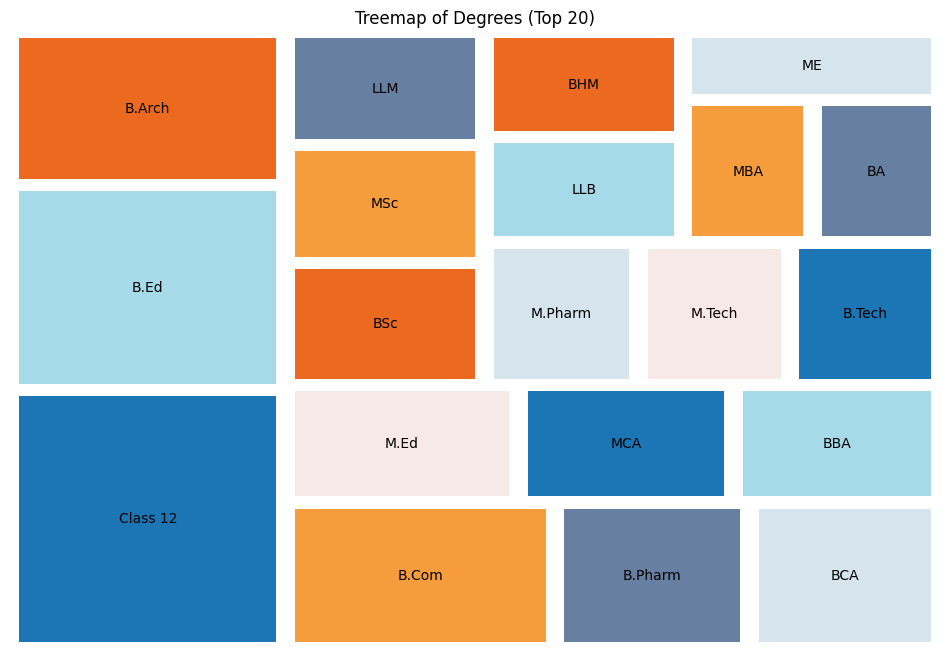

In [ ]:
# Calculate frequencies
value_counts = df_train['Degree'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=value_counts.index[:20], color=colors, pad=True)
plt.title(f"Treemap of Degrees (Top 20)")
plt.axis("off")
plt.show()

In [ ]:
# Get the top 10 most common professions
top_professions = df_train['Degree'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 professions
filtered_df = df_train[df_train['Degree'].isin(top_professions)]

# Create a new DataFrame for aggregation
agg_data = filtered_df.groupby(['Degree', 'Depression']).size().reset_index(name='Count')

# Create a sunburst chart
fig = px.sunburst(agg_data,
                  path=['Degree', 'Depression'],
                  values='Count',
                  title='Sunburst Chart of Top 10 Degrees and Depression',
                  color='Count',
                  color_continuous_scale=px.colors.sequential.Oranges[:])

# Show the figure
fig.show()

3.7. Distribution of a Target Variable

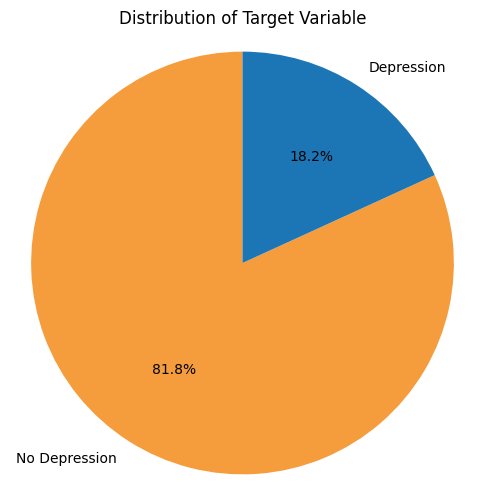

In [ ]:
# Calculate counts for the pie chart and add labels
class_counts = df_train[target_column].value_counts().sort_index()
labels = ["No Depression", "Depression"]
plt.figure(figsize=(6, 6))
plt.pie(class_counts, colors=bi_palette, labels=labels,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

3.8. Correlation between Variables

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr(numeric_only=True)

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(correlation_matrix,
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Correlation Matrix',
                aspect='auto')

# Show the plot
fig.show()

3.9. Depression by Age and Work Pressure

In [ ]:
# Drop rows with NaN values in 'Age', 'Work Pressure', and 'Depression' columns
df_train_copy = df_train.dropna(subset=['Age', 'Work Pressure', 'Depression'])

# Create bins for Age and Work Pressure
df_train_copy['Age_bin'] = pd.cut(df_train_copy['Age'], bins=10).astype(str)           # Convert the bins to strings (to avoid serialization issues)
df_train_copy['WorkPressure_bin'] = pd.cut(df_train_copy['Work Pressure'], bins=10).astype(str)

# Create pivot table
heatmap_data = df_train_copy.pivot_table(index='Age_bin', columns='WorkPressure_bin', values='Depression', aggfunc='mean')

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(heatmap_data.values,  # Use only the numerical matrix
                labels=dict(x="Work Pressure Bin", y="Age Bin", color="Depression"),
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Depression by Age and Work Pressure',
                aspect='auto')

# Set the y-axis and x-axis tick labels to the actual bin ranges
fig.update_layout(
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.index))),  # Set tick positions
        ticktext=heatmap_data.index.astype(str).tolist()  # Convert intervals to strings for labels
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.columns))),  # Set tick positions
        ticktext=heatmap_data.columns.astype(str).tolist()  # Convert intervals to strings for labels
    )
)

# Show the plot
fig.show()